In [15]:
import tensorflow as tf

# Import TensorFlow Datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt


In [16]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [17]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset.get('train'), dataset.get('test')

In [18]:
class_names = metadata.features['label'].names
print("Class names: {}".format(class_names))

Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [19]:
# normalize the images
def normalize(images, labels):
    images = tf.cast(images, tf.float32)
    images /= 255
    return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

2022-12-26 21:17:35.985730: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


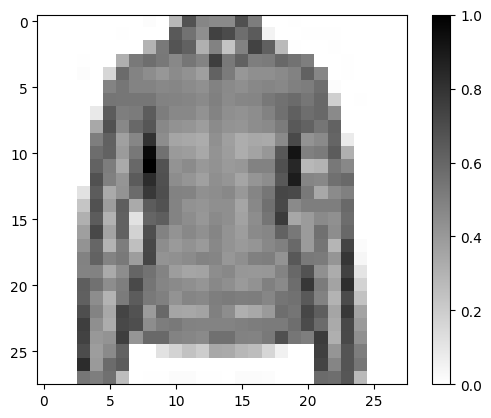

In [20]:
# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

# Plot the image - voila a piece of fashion clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

2022-12-26 21:17:36.652123: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


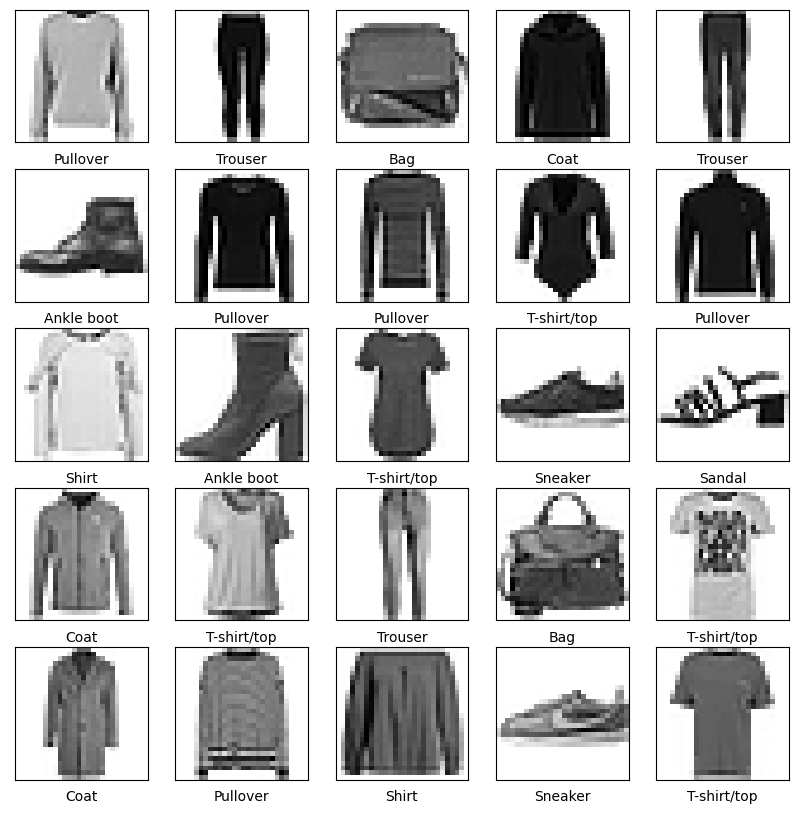

In [21]:
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(train_dataset.take(25)):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
plt.show()

In [30]:
def load_dataset():
    # load MNIST dataset
    dataset, metadata = tfds.load('mnist', as_supervised=True, with_info=True)
    train_dataset, test_dataset = dataset['train'], dataset['test']

    # prepare dataset
    num_train_examples = metadata.splits['train'].num_examples
    num_test_examples = metadata.splits['test'].num_examples
    BATCH_SIZE = 32
    train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
    test_dataset = test_dataset.cache().batch(BATCH_SIZE)
    return train_dataset, test_dataset

def build_model(number_of_layers=1, number_of_neurons=512, activation_function='relu'):
    # build model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(28, 28, 1)))
    for i in range(number_of_layers):
        model.add(tf.keras.layers.Dense(number_of_neurons, activation=activation_function))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    return model

def train_model(model, train_dataset):
    # train model
    # get number of train examples
    num_train_examples = metadata.splits['train'].num_examples
    BATCH_SIZE = 32
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    model.fit(train_dataset, epochs=1, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))
    return model

def evaluate_model(model, test_dataset):
    # evaluate model
    num_test_examples = metadata.splits['test'].num_examples
    BATCH_SIZE = 32
    test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/BATCH_SIZE))
    print('Accuracy on test dataset:', round(test_accuracy, 2))
    return test_accuracy


In [38]:
train_dataset, test_dataset = load_dataset()

# save results
results = []

# run grid search on number of layers and number of neurons
for number_of_layers in range(1, 5):
    for number_of_neurons in [16, 32, 64, 128, 256, 512]:
        model = build_model(number_of_layers=number_of_layers, number_of_neurons=number_of_neurons, activation_function='relu')
        train_model(model, train_dataset)
        test_accuracy = evaluate_model(model, test_dataset)
        results.append({'number_of_layers': number_of_layers, 'number_of_neurons': number_of_neurons, 'test_accuracy': test_accuracy})



313/313 [==============================] - 0s 886us/step - loss: 1.7683 - accuracy: 0.3433
Accuracy on test dataset: 0.34
313/313 [==============================] - 0s 795us/step - loss: 0.8482 - accuracy: 0.7909
Accuracy on test dataset: 0.79
313/313 [==============================] - 0s 816us/step - loss: 0.6300 - accuracy: 0.8418
Accuracy on test dataset: 0.84
313/313 [==============================] - 0s 892us/step - loss: 0.5860 - accuracy: 0.8952
Accuracy on test dataset: 0.9
313/313 [==============================] - 1s 3ms/step - loss: 0.5050 - accuracy: 0.9208
Accuracy on test dataset: 0.92
313/313 [==============================] - 1s 2ms/step - loss: 0.5070 - accuracy: 0.9284
Accuracy on test dataset: 0.93
313/313 [==============================] - 0s 1ms/step - loss: 1.2876 - accuracy: 0.4693
Accuracy on test dataset: 0.47
313/313 [==============================] - 0s 844us/step - loss: 0.6564 - accuracy: 0.8434
Accuracy on test dataset: 0.84
313/313 [======================

In [2]:
# plot results in 3d plot
import plotly.graph_objects as go
import pandas as pd

df = pd.DataFrame(results)
fig = go.Figure(data=[go.Surface(z=df['test_accuracy'].values.reshape(6,4), x=df['number_of_neurons'].unique(), y=df['number_of_layers'].unique())])
fig.update_layout(title='MNIST test accuracy', autosize=False,
                    width=500, height=500,  
                    margin=dict(l=65, r=50, b=65, t=90))
# update axes labels on 3d plot
fig.update_layout(scene = dict(
                    xaxis_title='Number \n neurons',
                    yaxis_title='Number of layers',
                    zaxis_title='Test accuracy'))
fig.show()


NameError: name 'results' is not defined

In [1]:
# plot 2d heatmap of dataframe
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(results)
df = df.pivot('number_of_layers', 'number_of_neurons', 'test_accuracy')
plt.figure(figsize=(10, 10))
sns.heatmap(df, annot=True, fmt='.2f', cmap='Blues')
plt.show()


NameError: name 'pd' is not defined